# Obligatorio Machine Learning para IA

### Ramiro Sanes y Joaquin Guerra

In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from skimage import data, color
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
from random import sample
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
import joblib
import imageio.v2 as imageio

## Tarea 1

Generar un conjunto de datos con imagenes de fondo (sin rostros)

Descomprimimos la carpeta con imágenes caseras "Background" y cargamos otras imágenes de scikit learn

In [3]:
import zipfile

with zipfile.ZipFile('Background.zip', 'r') as zip_ref:
    zip_ref.extractall('Background')

In [4]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field',
        #'astronaut',
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    #images.append(resize(img, (100,100),preserve_range=True))
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
for i in range(31):
    #filename = "Background\\" + str(i) + ".jpg"
    filename = f"Background/{i}.jpg"
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    #images.append(resize(img, (100,100),preserve_range=True))
    images.append(resize(img, (100,100)))

Visualizamos las 40 imágenes (31 caseras + 9 de sklearn)

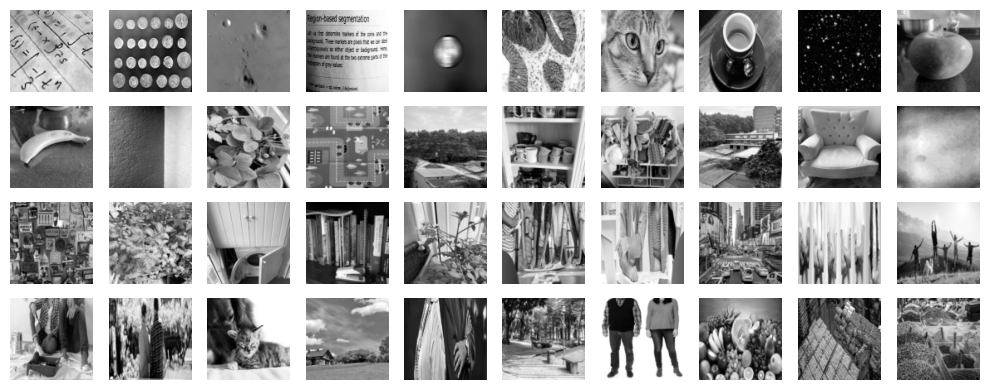

In [5]:
# Visualización
fig, ax = plt.subplots(4, 10, figsize=(10, 4), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(len(images)):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Los rostros son de 64x64 por lo que vamos a usar parches de 64x64
size = (64, 64)

In [7]:
#Definimos funcion para extraer N parches de una imagen
def extract_patches(img,N,scale=1.0,patch_size = size):
    """
    Extrae N parches de una imagen
    :param image: Imagen de entrada
    :param N: Cantidad de parches a extraer
    :param scale: Escala de la imagen (1.0 = original)
    :param patch_size: Tamaño del parche
    :return: Parche extraido
    """
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        #patches = np.array([resize(patch, patch_size,preserve_range=True) for patch in patches])
        patches = np.array([resize(patch, patch_size) for patch in patches])


    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [8]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 150, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]


(30000, 64, 64)

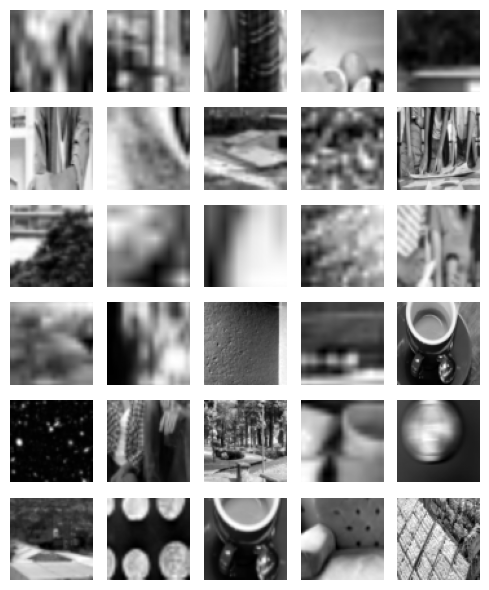

In [9]:
# Visualizamos una muestra
samples = sample(range(negative_patches.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

## Tarea 2

Evaluar la técnica de componentes principales (PCA) para la clasificacion de rostros

In [10]:
import zipfile

with zipfile.ZipFile('Faces.zip', 'r') as zip_ref:
    zip_ref.extractall('Faces')

In [11]:
suffix = '.pgm'

all_files = os.listdir('Faces/Faces')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [12]:
faces = []
for filename in tqdm(pgm_files):
    path = os.path.join('Faces/Faces', filename)
    image = imageio.imread(path)  # mucho más rápido que plt.imread
    faces.append(image)

100%|██████████| 12833/12833 [00:08<00:00, 1561.77it/s]


In [13]:
faces_array = np.stack(faces)

In [14]:
faces_array = faces_array / 255.0
print(faces_array[0])

[[0.23921569 0.25490196 0.26666667 ... 0.34117647 0.32156863 0.30196078]
 [0.23921569 0.25098039 0.25882353 ... 0.3372549  0.30588235 0.27843137]
 [0.24313725 0.25098039 0.25098039 ... 0.3372549  0.29019608 0.25882353]
 ...
 [0.30588235 0.30980392 0.29803922 ... 0.25490196 0.23137255 0.21568627]
 [0.28627451 0.31372549 0.29019608 ... 0.22352941 0.20784314 0.2       ]
 [0.3254902  0.29411765 0.28235294 ... 0.2        0.19215686 0.20392157]]


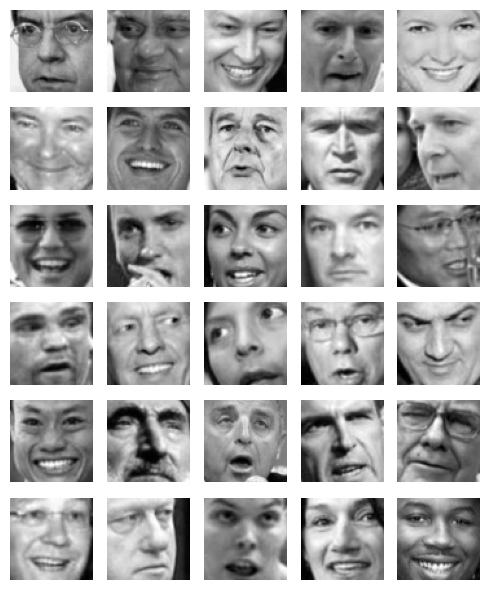

In [15]:
# Visualizamos una muestra
samples = sample(range(faces_array.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces_array[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [16]:
print(type(faces_array))
print(type(negative_patches))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
X_faces = faces_array
y_faces = [1] * len(X_faces)  # Etiquetas para las imágenes de rostros
X_fondos = negative_patches
y_fondos = [0] * len(X_fondos)  # Etiquetas para las imágenes de fondo

In [18]:
print("Media - Rostros:", np.mean(X_faces))
print("Media - Fondos:", np.mean(X_fondos))

Media - Rostros: 0.5020220533773168
Media - Fondos: 0.4879994730559517


In [19]:
X = np.vstack([X_faces,X_fondos])
y = np.hstack([y_faces,y_fondos])  # Etiquetas combinadas

In [20]:
print(X.shape, y.shape)

(42833, 64, 64) (42833,)


Aplanamos las imagenes

In [21]:
X_flatten = np.array([im.flatten() for im in tqdm(X, desc='Construyendo X')])

Construyendo X: 100%|██████████| 42833/42833 [00:01<00:00, 38234.74it/s]


In [22]:
X_faces_flatten = np.array([im.flatten() for im in tqdm(X_faces, desc='Construyendo X')])
X_fondos_flatten = np.array([im.flatten() for im in tqdm(X_fondos, desc='Construyendo X')])

Construyendo X: 100%|██████████| 30000/30000 [00:00<00:00, 60587.28it/s]


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_flatten, y, test_size=0.1, random_state=42)

In [24]:
pca_200 = PCA(n_components=200, whiten=True)
pca_200.fit(X_train)

PCA(n_components=200, whiten=True)

Varianza explicada con 200 componentes: 0.9658470911429318


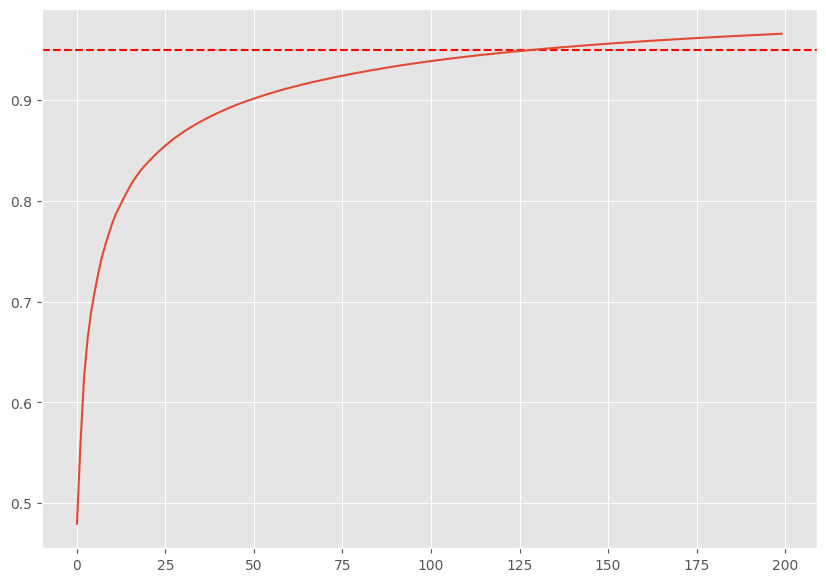

In [25]:

print(f"Varianza explicada con 200 componentes: {np.sum(pca_200.explained_variance_ratio_)}")
#print(f"Varianza explicada acumulada con {i} componentes: {np.cumsum(pca_dict[i].explained_variance_ratio_)}")

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.plot(np.cumsum(pca_200.explained_variance_ratio_), label=f'{200} componentes')
plt.show()

Observamos que a partir de 125 acumula más del 95% de la varianza explicada, por lo que observamos a partir de explained_variance_ratio_ cual es la cantidad de componentes principales a tomar.

In [26]:
np.cumsum(pca_200.explained_variance_ratio_[:135])

array([0.47955265, 0.55907236, 0.62430493, 0.66284157, 0.6898129 ,
       0.70967427, 0.72762578, 0.74353655, 0.75608221, 0.76728974,
       0.77812097, 0.78707484, 0.79420531, 0.80118678, 0.8080198 ,
       0.81451017, 0.82044098, 0.82544749, 0.83027192, 0.83432244,
       0.83805564, 0.84175649, 0.84535801, 0.84873105, 0.85192084,
       0.85496446, 0.85790325, 0.86071676, 0.86337979, 0.86588286,
       0.86827133, 0.87053274, 0.87271657, 0.87481611, 0.87684992,
       0.87882265, 0.88070105, 0.88255405, 0.88433092, 0.88605015,
       0.88767062, 0.88924702, 0.89079116, 0.89231124, 0.89379385,
       0.89522781, 0.89656869, 0.89786427, 0.89914288, 0.90036479,
       0.90157694, 0.90274711, 0.90389285, 0.90501326, 0.90610988,
       0.90720001, 0.90826487, 0.90929253, 0.91028335, 0.91126438,
       0.91219223, 0.91309355, 0.913985  , 0.91486473, 0.91573316,
       0.91659246, 0.91741668, 0.9182293 , 0.91903183, 0.91981861,
       0.92058712, 0.92134999, 0.92209537, 0.92283166, 0.92354

In [27]:
cant_pca = np.argmin(np.abs(np.cumsum(pca_200.explained_variance_ratio_[:135]) - 0.95)) + 1

In [28]:
print(f"La cantidad de componentes principales que más se acerca al 95% definido como umbral son: {cant_pca}")

La cantidad de componentes principales que más se acerca al 95% definido como umbral son: 130


Tomamos 130 como la cantidad de componentes principales ya es la cantidad que más se approxima al 95% de la varianza explicada que definimos commo umbral.

In [29]:
pca_final = PCA(n_components=130, whiten=True)
pca_final.fit(X_train)

PCA(n_components=130, whiten=True)

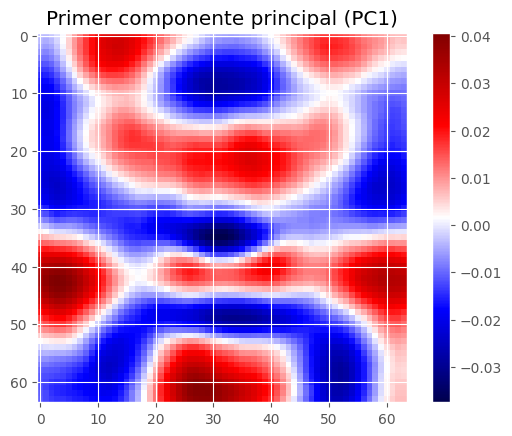

In [30]:
pc1 = pca_final.components_[20]  # Shape: (4096,)

# Visualizarlo como imagen (reshape 64x64)
plt.imshow(pc1.reshape(64, 64), cmap='seismic')
plt.title("Primer componente principal (PC1)")
plt.colorbar()
plt.show()

### Visualizamos las primeras componentes

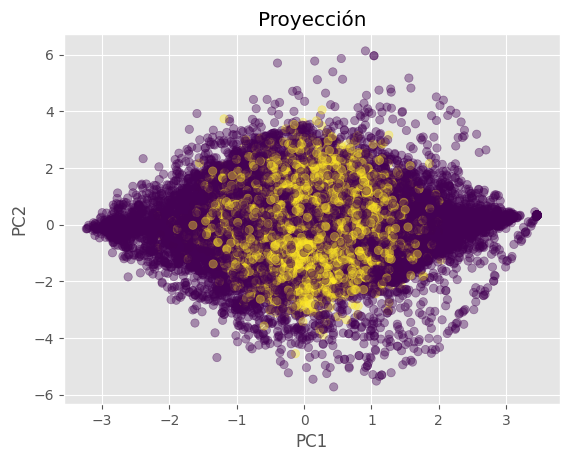

In [31]:
X_pca_train = pca_final.transform(X_train)

plt.scatter(X_pca_train[:,0], X_pca_train[:,1], alpha=0.4,c=y_train)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

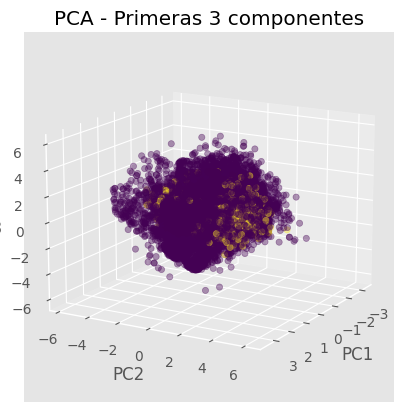

In [32]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca_train[:,0], X_pca_train[:,1], X_pca_train[:,2], alpha=0.4,c=y_train)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

Podemos observar que con los 2 componentes principales, es notoria la división entre datos etiquetados como caras y datos etiquetados como fondos.
Cuando haciamos PCA solo en las caras, la cantidad de componenetes era 180, porque capturar la varianza de caras que son muy similares entre si, es mucho mas complejo que capturarla en caras y fondos juntos.

In [33]:
df = pd.DataFrame(X_pca_train, columns=[f'PC{i+1}' for i in range(X_pca_train.shape[1])])
df['y'] = y_train
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,y
0,-0.304755,0.161190,1.747835,0.262563,0.238081,0.796643,0.121292,-0.481385,0.628798,-0.631062,...,-0.096947,0.068883,0.106410,-0.065265,-0.039057,-0.135028,-0.210705,0.024507,0.018056,0
1,0.856588,-1.397784,0.652677,1.449227,-1.106793,0.377570,-0.401049,0.768502,-0.530266,-0.264527,...,-0.127588,-0.304587,-0.453459,-0.177448,0.365290,-0.110122,-0.262723,0.170369,0.760852,0
2,-0.088057,-2.838295,1.411592,0.582196,1.436441,1.859811,-0.280928,-2.784214,-0.804780,0.926331,...,-0.003739,-0.202062,-0.030688,0.063263,-0.049693,-0.179719,-0.095496,0.069449,-0.043373,0
3,0.892611,-0.551758,-0.548142,-1.149423,-0.495503,0.836958,1.291423,0.682741,-0.827677,-0.420255,...,1.197323,-3.091052,3.372822,-0.313694,1.525867,-0.558531,0.944078,0.170147,-1.053128,1
4,-0.483730,-0.046595,0.280705,0.224528,0.093988,0.063145,-0.559660,-0.190011,-0.058393,-0.139769,...,-0.223937,0.088494,-0.028519,-0.053631,-0.138596,0.145024,-0.162739,-0.303953,-0.015424,0


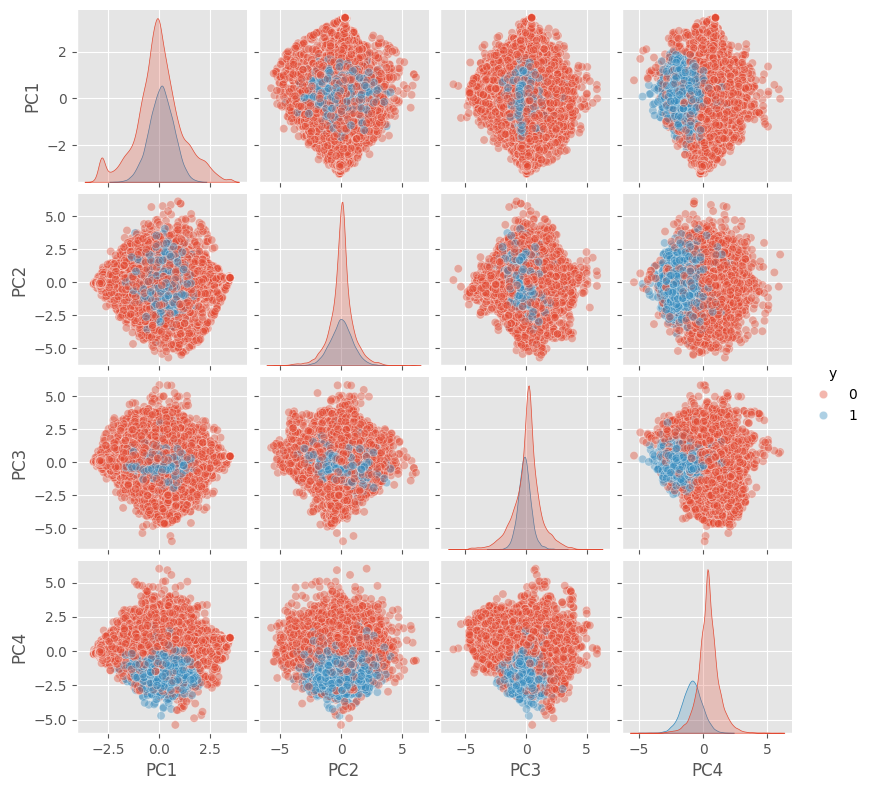

In [34]:
sns.pairplot(df, vars=['PC1','PC2','PC3','PC4'], diag_kind='kde', height=2, plot_kws={'alpha':0.4}, hue='y',)
plt.show()

### Modelo sencillo de clasificación

In [35]:
tree_dict = {}
scores = {}
for i in [1,2,5,10,None]:
    tree_dict[i] = DecisionTreeClassifier(max_depth=i,random_state=42)
    scores[i] = cross_val_score(tree_dict[i], X_pca_train, y_train, cv=5, scoring='accuracy')
    print(f"Score con {i} profundidad: {np.mean(scores[i])}")



Score con 1 profundidad: 0.8241720131387522
Score con 2 profundidad: 0.8769618578786498
Score con 5 profundidad: 0.9492853216690987
Score con 10 profundidad: 0.9597136030637123
Score con None profundidad: 0.9560818145247382


In [36]:
tree_final = DecisionTreeClassifier(max_depth=10,random_state=42)
tree_final.fit(X_pca_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [37]:
X_pca_val = pca_final.transform(X_val)

In [38]:
print(tree_final.score(X_pca_val, y_val))

0.9647525676937442


### Probamos en Test

In [39]:
import zipfile

with zipfile.ZipFile('Test.zip', 'r') as zip_ref:
    zip_ref.extractall('Test')

In [40]:
suffix = '.pgm'

all_files = os.listdir('Test/Test')
pgm_files_test = [filename for filename in all_files if filename.endswith(suffix)]

In [41]:
test_images = []
for filename in tqdm(pgm_files_test):
    path = os.path.join('Test/Test', filename)
    image = imageio.imread(path)  # mucho más rápido que plt.imread
    test_images.append(image)

100%|██████████| 8000/8000 [00:04<00:00, 1750.04it/s]


In [42]:
test_array = np.stack(test_images)

In [43]:
test_array = test_array / 255.0

In [44]:
test_array.shape

(8000, 64, 64)

In [45]:
X_test_flatten = np.array([im.flatten() for im in tqdm(test_array, desc='Construyendo X')])

Construyendo X: 100%|██████████| 8000/8000 [00:00<00:00, 104221.52it/s]


In [46]:
print("Media - Test:", np.mean(X_test_flatten))

Media - Test: 0.4885256642061116


In [47]:
X_test_pca = pca_final.transform(X_test_flatten)

In [48]:
y_test = tree_final.predict(X_test_pca)

In [49]:
test_df = pd.DataFrame(X_test_flatten)

In [50]:
test_df['prediccion'] = y_test

In [51]:
test_df.value_counts('prediccion')

,count
prediccion,
0,7400
1,600


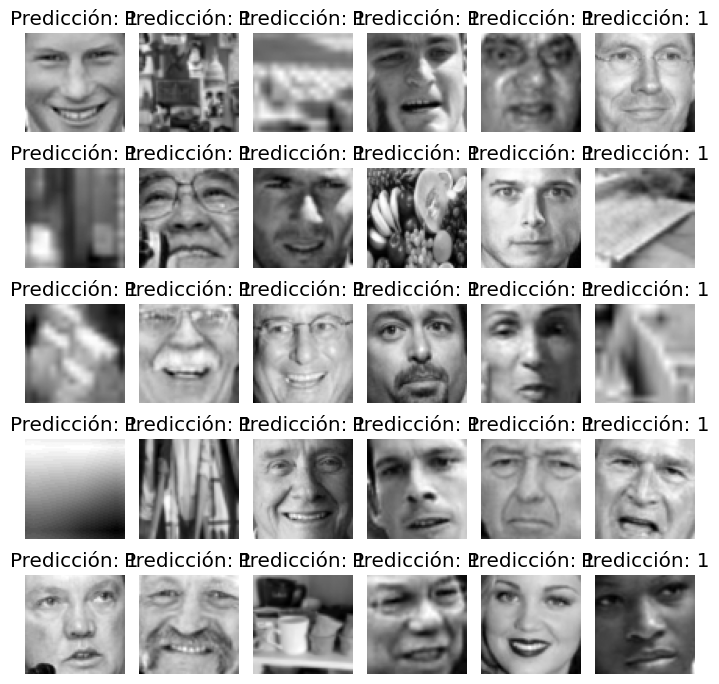

In [52]:
# muestro 10 imagenes de test_df que tengan prediccion 1
samples = sample(test_df[test_df['prediccion'] == 1].index.tolist(), 30)
fig, ax = plt.subplots(5, 6, figsize=(7, 7))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_array[samples[i]], cmap='gray')
    axi.axis('off')
    axi.set_title(f"Predicción: {test_df['prediccion'].iloc[samples[i]]}")
plt.tight_layout()
plt.show()

In [53]:
joblib.dump(tree_final, 'modelos/modelo_tree_10_315v1.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'modelos/modelo_tree_10_315v1.pkl'

In [ ]:
joblib.dump(pca_final, 'modelos/pca_final_130_315v1.pkl')

In [ ]:
# Visualizamos una muestra
samples = sample(range(test_array.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_array[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

Prueba Random Forest


In [54]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_pca_train, y_train, test_size=0.1, random_state=42)

In [57]:
dict_randomForest = {}
for i in [10,100,200]:
    dict_randomForest[i] = RandomForestClassifier(n_estimators=i, random_state=42)
    print(f'El score con {i} árboles es:')
    # Accuracy en train sin cross validation
    dict_randomForest[i].fit(X_train_rf, y_train_rf)
    print(dict_randomForest[i].score(X_train_rf, y_train_rf))
    # Accuracy en test sin cross validation
    print(dict_randomForest[i].score(X_test_rf, y_test_rf))



El score con 10 árboles es:
0.9984435349051709
0.9535667963683528
El score con 100 árboles es:
1.0
0.9750972762645914
El score con 200 árboles es:
1.0
0.9771725032425421


In [58]:
test_accuracy = dict_randomForest[100].score(X_pca_val, y_val)
print("Accuracy en test:", test_accuracy)

Accuracy en test: 0.9752567693744164


Probamos en test Kaggle

In [59]:
y_pred_rf_model = dict_randomForest[100].predict(X_test_pca)

In [60]:
df_pred_rf_model = pd.DataFrame(X_test_flatten)

In [61]:
df_pred_rf_model['prediccion'] = y_pred_rf_model

In [62]:
df_pred_rf_model.value_counts('prediccion')

,count
prediccion,
0,7606
1,394


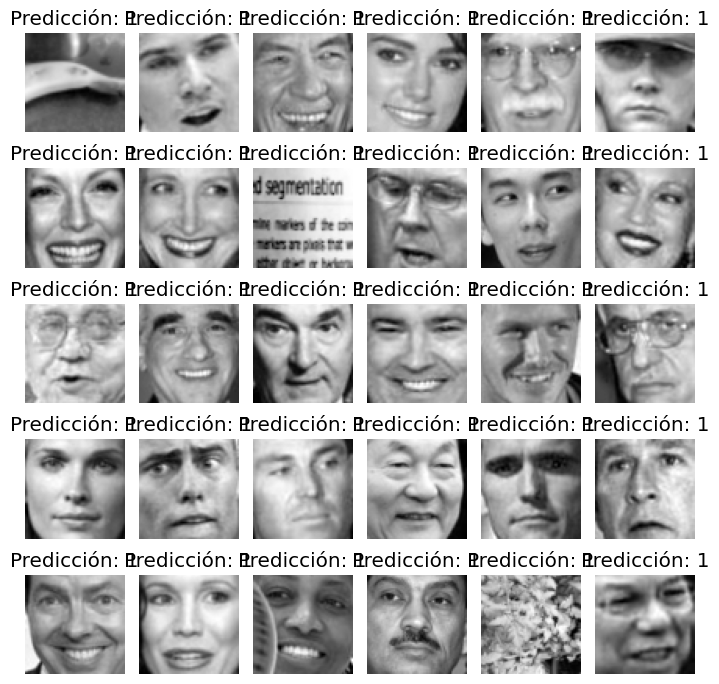

In [64]:
#imprimir las primeras 20 imagenes de test_array donde la prediccion es 1
samples = sample(df_pred_rf_model[df_pred_rf_model['prediccion'] == 1].index.tolist(), 30)
fig, ax = plt.subplots(5, 6, figsize=(7, 7))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_array[samples[i]], cmap='gray')
    axi.axis('off')
    axi.set_title(f"Predicción: {df_pred_rf_model['prediccion'].iloc[samples[i]]}")
plt.tight_layout()
plt.show()

In [66]:
joblib.dump(dict_randomForest[100], 'random_forest_100_315v1.pkl')

['random_forest_100_315v1.pkl']